# PennyLane. Оптимизация параметров квантовых схем. Квантовое ускорение комбинаторной оптимизации
## План занятия
- Основные понятия PennyLane
- Градиентный спуск
- Оптимизация параметров квантовых схем с помощью градиентного спуска
- Комбинаторная оптимизация
- Квантовая приблизительная оптимизация
- Решение задачи максимальной клики

## Особенности PennyLane
- Работа с разными квантовыми компьютерами, в том числе одновременно.
- Оптимизация структуры для создания квантовых многослойных параметризованных схем.
- Набор функций высокого уровня абстракции для оптимизации и машинного обучения.

Установка через pip. Инструкции приведены по ссылке:
https://pennylane.ai/install.html?version=stable

Основные понятия:
- quantum functions
- quantum nodes
- templates
- измерения
- devices
- плагины

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

mpl.rcParams['figure.dpi'] = 150

### Quantum functions
Квантовые функции -- подмножество функций python. Они могут состоять только из последовательных квантовых команд и возвращать либо None, либо результаты измерений. Функции могут быть параметризованы. Пример корректной квантовой функции:

In [2]:
def bell_state_rotated(angle_x):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(angle_x, wires=0)
    return qml.probs(wires=[0,1])

Список всех квантовых операций доступен по адресу:
    https://pennylane.readthedocs.io/en/stable/introduction/operations.html

### Quantum Nodes and Devices
При попытке выполнить функцию мы получим бессмысленный результат:

In [3]:
bell_state_rotated(0)

probs(wires=[0, 1])

Дело в том, что библиотека не знает, где эту функцию выполнять. Для этого нужно преобразовать квантовую функцию в квантовую ноду -- схему с возвращаемым значением, которая может быть выполнена на конкретном квантовом устройстве. PennyLane поддерживает много разных квантовых компьютеров и симуляторов, в частности:
- Сверхпроводящие компьютеры и симуляторы IBM
- Оптические компьютеры и симуляторы Xanadu
- Компьютеры на ионах и симуляторы Rigetti

Помимо этого, в PennyLane встроены собственные эмуляторы для кубитного и оптического компьютеров.
Взаимодействие с квантовыми устройствами осуществляется через плагины. Это интерфейсы, позволяющие выполнять код на устройствах и понимать из API.
<img src="pennylane_plugins.png">

Для определения устройства используется класс **pennylane.device**. Будем выполнять код на встроенном эмуляторе:

In [4]:
dev = qml.device('default.qubit', wires=2)

Чтобы указать, на каком устройстве будет выполняться та или иная функция, используется класс **pennylane.QNode** или декоратор **pennylane.qnode**. Следующие записи эквивалентны:

In [14]:
bell_state_rotated_circuit = qml.QNode(bell_state_rotated, dev)

@qml.qnode(dev)
def bell_state_rotated_circuit(angle_x):
    return bell_state_rotated(angle_x)

Квантовые ноды могут объединяться в коллекции, причем разные элементы коллекции могут выполняться на разных устройствах! Таким образом, исполняемый код полностью отвязан от конкретной реализации квантового компьютера. Например, создадим экземпляр функции **bell_state_rotated**, выполняемый на эмуляторе qiskit.

In [6]:
from qiskit import IBMQ

provider = IBMQ.load_account()
dev_ibm = qml.device('qiskit.aer', wires=2, backend='qasm_simulator', shots=1024)

In [7]:
bell_state_rotated_circuit_ibm = qml.QNode(bell_state_rotated, dev_ibm)

In [8]:
qnodes = qml.QNodeCollection([bell_state_rotated_circuit, bell_state_rotated_circuit_ibm])

In [21]:
qnodes(0), qnodes(np.pi / 2)

array([[0.5       , 0.        , 0.        , 0.5       ],
       [0.48046875, 0.        , 0.        , 0.51953125]])

### Templates and measurements
Для облегчения создания квантовых схем можно использовать шаблоны **pennylane.template**. Это функции, содержащие части квантовой схемы и не содержащие измерений. Например, написанные выше функции можно изменить с использованием шаблона:

In [10]:
@qml.template
def bell_state_rotated_template(angle_x):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.RX(angle_x, wires=0)
    
@qml.qnode(dev)
def bell_state_rotated_probs(angle_x):
    bell_state_rotated_template(angle_x)
    return qml.probs(wires=[0,1])

@qml.qnode(dev)
def bell_state_rotated_sample(angle_x):
    bell_state_rotated_template(angle_x)
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))

@qml.qnode(dev)
def bell_state_rotated_expval(angle_x):
    bell_state_rotated_template(angle_x)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

@qml.qnode(dev)
def bell_state_rotated_var(angle_x):
    bell_state_rotated_template(angle_x)
    return qml.var(qml.PauliZ(0)), qml.var(qml.PauliZ(1))

Распределение вероятностей для базисных состояний

In [23]:
bell_state_rotated_probs(np.pi / 2)

tensor([0.25, 0.25, 0.25, 0.25], requires_grad=True)

Результаты, полученные в каждом из измерений

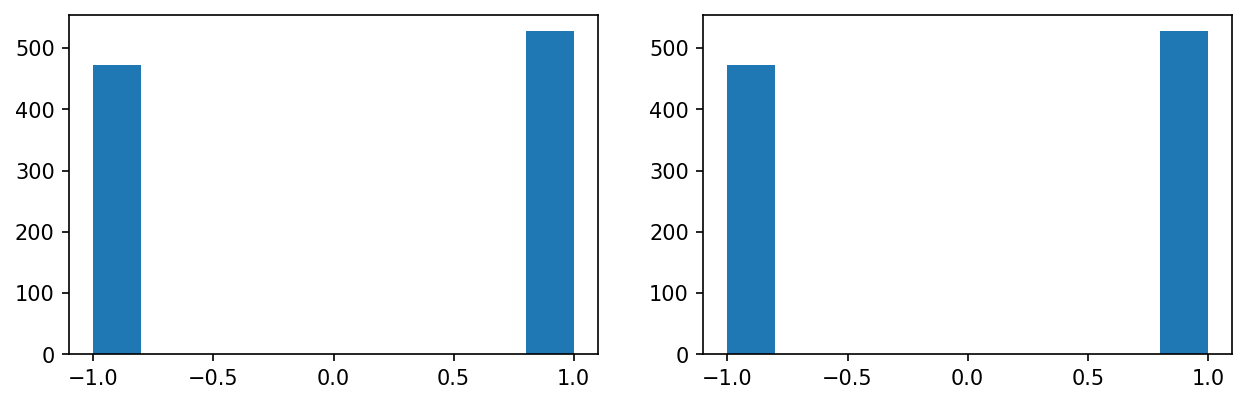

In [28]:
sz0, sz1 = bell_state_rotated_sample(0)
fig, ax = plt.subplots(1,2, figsize=(10, 3))
ax[0].hist(sz0)
ax[1].hist(sz1)
plt.show()

Ожидаемые значения и их дисперсии

In [29]:
bell_state_rotated_expval(np.pi), bell_state_rotated_var(np.pi)

(tensor([0., 0.], requires_grad=True), tensor([1., 1.], requires_grad=True))